In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
sys.path.append('..')
from src.ham_to_sparse_matrix import *
from src.constants import *
from src.matrix_to_ps import matrix_to_pauli_strings
from src.binary_encodings import *

import sympy as sp
import sys
import scipy.sparse.linalg

In [22]:
bosonNI=sp.expand( pn**2/(2*aLat) + (aLat/2)*((qnP1-qnM1)/(2*aLat))**2 )
bosonI=sp.expand( (aLat/2)*V(qn)**2 + aLat*V(qn)*(qnP1-qnM1)/(4*aLat) + aLat*(qnP1-qnM1)*V(qn)/(4*aLat) )
fermionNI=sp.expand( -(xdnP1*xn+xdn*xnP1)/(2*aLat) )
fermionI=sp.expand( sp.diff(V(qn),qn)*(xdn*xn-(1/2)) )

In [23]:
N=2
aVal=1

# depends on finite-difference method
qs=[SiteSymbol('q',str(i)) for i in range(-1,N+1,1)]
# maybe make qs a normal site list
# and make an extra boundaryQs list for q[-1], q[N]
# counting would be normal computer science way for rest of code.

ps=[SiteSymbol('p',str(i)) for i in range(-1,N+1,1)] # don't really need extras
aops=[SiteSymbol('a',str(i)) for i in range(-1,N+1,1)]
adags=[SiteSymbol('a^{\dagger}',str(i)) for i in range(-1,N+1,1)]
xs=[SiteSymbol('\chi',str(i)) for i in range(-1,N+1,1)]
xdags=[SiteSymbol('\chi^{\dagger}',str(i)) for i in range(-1,N+1,1)]

# note this is exactly hardcoded for this finite difference method.
bcType = 'dirichlet'
boundaryConditions = {}
if bcType == 'periodic':
    boundaryConditions = {qs[0]: qs[N], qs[N+1]: qs[1],
                          xs[0]: -xs[N], xs[N+1]: -xs[1], 
                          xdags[0]: -xdags[N],  xdags[N+1]: -xdags[1]
                         }
    
elif bcType == 'dirichlet':
    boundaryConditions = { qs[0]: 0, qs[N+1]: 0,
                          xs[0]: 0, xs[N+1]: 0,
                          xdags[0]: 0, xdags[N+1]:0
                         }

In [24]:
ham=0

mass=1

for i in range(1,N+1):
    ham+=(bosonNI+bosonI+fermionNI).subs({
        pn: ps[i],
        qn: qs[i], qnP1: qs[i+1], qnM1: qs[i-1],
        xn: xs[i], xnP1: xs[i+1],
        xdn: xdags[i], xdnP1: xdags[i+1]
    }).subs(boundaryConditions)

def potential(n):
    # m*q with m=1
    return -mass*qs[n]

potentialSubs={}
for n in range(1,N+1):
    potentialSubs[V(qs[n])]=potential(n)


ham=sp.simplify(ham.subs(potentialSubs).subs(aLat,aVal))

for i in range(1,N+1):
    if i%2==0:
        ham+=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
    else:
        ham-=sp.simplify(fermionI.subs({qn: qs[i], xn: xs[i], xdn: xdags[i]}).subs(potentialSubs))
ham=sp.simplify(ham.subs(aLat,aVal))
sp.expand(ham)

\chi^{\dagger}_{0}*\chi_{0} - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 - \chi^{\dagger}_{1}*\chi_{1} + p_{0}**2/2 + p_{1}**2/2 + 5*q_{0}**2/8 + 5*q_{1}**2/8

In [25]:
m=1

HOdofSubs = {}
#offset because of BC
for i in range(1,N+1):
    HOdofSubs[qs[i]] = 0.5*sp.sqrt(2/m)*(aops[i] + adags[i])
    HOdofSubs[ps[i]] = complex(0,1)*sp.sqrt(2*m)*(adags[i] - aops[i])/2 

hoHam=sp.expand(ham.subs(HOdofSubs))
hoHam=sp.nsimplify(hoHam,tolerance=1e-8)
hoHam

\chi^{\dagger}_{0}*\chi_{0} - \chi^{\dagger}_{0}*\chi_{1}/2 - \chi^{\dagger}_{1}*\chi_{0}/2 - \chi^{\dagger}_{1}*\chi_{1} + 9*a^{\dagger}_{0}*a_{0}/16 + a^{\dagger}_{0}**2/16 + 9*a^{\dagger}_{1}*a_{1}/16 + a^{\dagger}_{1}**2/16 + 9*a_{0}*a^{\dagger}_{0}/16 + a_{0}**2/16 + 9*a_{1}*a^{\dagger}_{1}/16 + a_{1}**2/16

In [26]:
from src.qiskit_utilities import *
from qiskit import Aer
from qiskit.utils import QuantumInstance

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes

from qiskit import qpy
from src.timer import *

import pickle

from qiskit import QuantumCircuit, transpile


backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)

In [19]:
for cutoff in [2,3,4,5,6,7,8]:
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]

    ps=matrix_to_pauli_strings(hamMat,standard_encode)
    op = pauli_string_to_op(ps)
    with open("Data/op_quad_cm0p2_lambda{}.pickle".format(cutoff), "wb") as f:
        pickle.dump(op, f)

    nq=math.floor(math.log2(hamMat.shape[0]))
    if not math.log2(hamMat.shape[0]).is_integer():
        nq+=1

    ansatz = RealAmplitudes(nq, reps=cutoff)

    
    vqe = VQE(ansatz=ansatz, optimizer=COBYLA(), quantum_instance=qinstance)
    results=[]
    for i in range(10):
        results.append(vqe.compute_minimum_eigenvalue(op).eigenvalue.real)

    print("{} & {:.2e} & {:.2e} \\\\".format(cutoff, np.min(ens).real, np.array(results).min()))
    
    qc = QuantumCircuit(nq,nq)
    qc.append(op_to_trotter(op,0.1), [i for i in range(nq)])
    tmp = transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z'])
    print("gates for one trotter step = ", tmp.count_ops().get('cx'))

--------- Lambda =  2  ----------
2 & 6.97e-03 & 6.97e-03 \\
gates for one trotter step =  8
--------- Lambda =  3  ----------
3 & -2.02e-02 & 1.08e-08 \\
gates for one trotter step =  3608
--------- Lambda =  4  ----------
4 & 3.22e-05 & 2.39e-04 \\
gates for one trotter step =  252
--------- Lambda =  5  ----------
5 & -5.40e-05 & 6.62e-04 \\
gates for one trotter step =  11104
--------- Lambda =  6  ----------
6 & 1.26e-07 & 1.97e-04 \\
gates for one trotter step =  14256
--------- Lambda =  7  ----------
7 & -1.75e-07 & 1.42e-02 \\
gates for one trotter step =  30590
--------- Lambda =  8  ----------
8 & 1.04e-09 & 9.70e-02 \\
gates for one trotter step =  2556


In [27]:
for cutoff in [2,4,6,8,10,12,14,16]:
    print("--------- Lambda = ", cutoff, " ----------")
    hamMat=convert_to_matrix(hoHam,cutoff,N,aops,adags,xs,xdags)
    ens=scipy.sparse.linalg.eigs(hamMat,k=6,sigma=0.0)[0]
    print(np.min(ens).real)

--------- Lambda =  2  ----------
0.006966007
--------- Lambda =  4  ----------
3.22491e-05
--------- Lambda =  6  ----------
1.2604747e-07
--------- Lambda =  8  ----------
1.0418005e-09
--------- Lambda =  10  ----------
5.5398935e-10
--------- Lambda =  12  ----------
5.410267e-10
--------- Lambda =  14  ----------
5.401959e-10
--------- Lambda =  16  ----------
5.3902816e-10


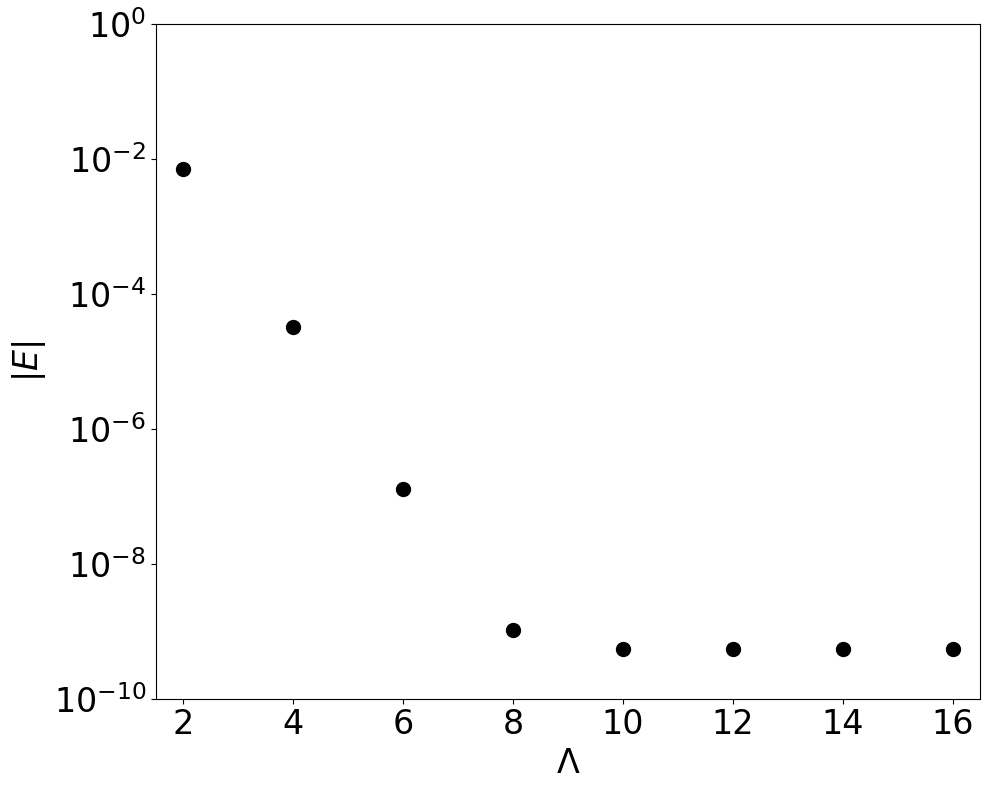

In [33]:
import matplotlib.pyplot as plt
import matplotlib 

ens=[0.006966007,3.22491e-05,1.2604747e-07,1.0418005e-09,5.5398935e-10,5.410267e-10,5.401959e-10,5.3902816e-10]

#matplotlib.use("Agg")
plt.style.use("paper.mplstyle")

fig, ax = plt.subplots()

plt.scatter([x for x in range(2,18,2)],[abs(en.real) for en in ens], c='black')
plt.yscale('log')

plt.xlabel('$\\Lambda$')
plt.ylabel('$|E|$')

plt.xlim(1.5,16.5)
plt.ylim(1e-10,1e0)
plt.yscale('log')

plt.savefig('Plots/WZ_2site_linear_classical.pdf',bbox_inches='tight')